# Определение перспективного тарифа для телеком-компании


**«Мегалайн»** — федеральный оператор сотовой связи, предлагающий клиентам два тарифных плана: **«Смарт»** и **«Ультра»**. Необходимо проанализировать поведение пользователей на небольшой выборке в 500 клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

Тариф **«Смарт»**:

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля;
    - сообщение: 3 рубля;
    - 1 Гб интернет-трафика: 200 рублей.
    
Тариф **«Ультра»**:

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль;
    - сообщение: 1 рубль;
    - 1 Гб интернет-трафика: 150 рублей.

**Описание данных**

1. Таблица ***users*** (информация о пользователях):

    - user_id — уникальный идентификатор пользователя;
    - first_name — имя пользователя;
    - last_name — фамилия пользователя;
    - age — возраст пользователя (годы);
    - reg_date — дата подключения тарифа (день, месяц, год);
    - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
    - city — город проживания пользователя;
    - tarif — название тарифного плана.
    
    
2. Таблица ***calls*** (информация о звонках):

    - id — уникальный номер звонка;
    - call_date — дата звонка;
    - duration — длительность звонка в минутах;
    - user_id — идентификатор пользователя, сделавшего звонок.
    
    
3. Таблица ***messages*** (информация о сообщениях):

    - id — уникальный номер сообщения;
    - message_date — дата сообщения;
    - user_id — идентификатор пользователя, отправившего сообщение.
    
    
4. Таблица **internet** (информация об интернет-сессиях):

    - id — уникальный номер сессии;
    - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах);
    - session_date — дата интернет-сессии;
    - user_id — идентификатор пользователя.
    
    
5. Таблица **tariffs** (информация о тарифах):

    - tariff_name — название тарифа;
    - rub_monthly_fee — ежемесячная абонентская плата в рублях;
    - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату;
    - messages_included — количество сообщений в месяц, включённых в абонентскую плату;
    - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
    - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
    - rub_per_message — стоимость отправки сообщения сверх тарифного пакета;
    - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).



## Общая информация

Импортируем библиотеки.

In [30]:
!pip install -U seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
!pip install termcolor
from termcolor import colored
from scipy import stats as st

Загрузим данные о пользователях, звонках, сообщениях, интернет-сессиях и тарифах в переменные.

In [31]:
calls, internet, messages, tariffs, users = (
    pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv'),  
    pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv'), 
    pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv'),
    pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv'),
    pd.read_csv('https://code.s3.yandex.net/datasets/users.csv') 
)

Для получения общей информации о датафреймах напишем следующую функцию:

In [32]:
def get_general_info(df):
    
    print(colored('Выведем первые 5 строк датафрейма:', attrs=['bold']))
    display(df.head())
    print('\n')
    print(colored('Общая информация по датафрейму:\n', attrs=['bold']))
    df.info()
    print('\n')
    print(colored('Основные статистические характеристики данных по числовым признакам:', attrs=['bold']))
    display(df.describe())
    print('\n')
    print(colored('Основные статистические характеристики данных по нечисловым признакам:', attrs=['bold']))
    display(df.describe(include=['object']))
    print('\n')
    print(colored('Количество пропущенных значений в датафрейме:', attrs=['bold']))
    display(df.isna().mean())
    print('\n')
    print(colored('Количество дубликатов в датафрейме: {}'.format(df.duplicated().sum()), attrs=['bold']))

1. Посмотрим общую информацию о **пользователях**  оператора сотовой связи:

In [33]:
get_general_info(users)

Выведем первые 5 строк датафрейма:


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra




Общая информация по датафрейму:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Основные статистические характеристики данных по числовым признакам:


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000




Основные статистические характеристики данных по нечисловым признакам:


,churn_date,city,first_name,last_name,reg_date,tariff
count,38,500,500,500,500,500
unique,33,76,246,419,270,2
top,2018-12-03,Москва,Радим,Андреенко,2018-05-28,smart
freq,2,99,6,5,8,351




Количество пропущенных значений в датафрейме:


user_id       0.000
age           0.000
churn_date    0.924
city          0.000
first_name    0.000
last_name     0.000
reg_date      0.000
tariff        0.000
dtype: float64



Количество дубликатов в датафрейме: 0


Датасет **users** содержит информацию о выборке клиентов оператора сотовой связи. Общая длина датафрейма равна 500 строкам, количество столбцов - 8. Есть пропуски в столбце `churn_date` с датой прекращения пользования тарифом, связанные с тем, что тариф ещё действовал на момент выгрузки данных

Столбцы содержат данные разных типов: 6 признаков имеют тип object и 2 признака — числовые.

В столбцe `reg_date`, содержащем информацию о дате подключения тарифа (день, месяц, год), данные переведем в формат datetime.

2. Посмотрим информацию о звонках, совершенных клиентами оператора.

In [34]:
get_general_info(calls)

Выведем первые 5 строк датафрейма:


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000




Общая информация по датафрейму:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Основные статистические характеристики данных по числовым признакам:


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000




Основные статистические характеристики данных по нечисловым признакам:


,id,call_date
count,202607,202607
unique,202607,365
top,1000_0,2018-12-31
freq,1,1435




Количество пропущенных значений в датафрейме:


id           0.0
call_date    0.0
duration     0.0
user_id      0.0
dtype: float64



Количество дубликатов в датафрейме: 0


Датасет **calls** содержит информацию о звонка, совершенных клиентами оператора сотовой связи. Общая длина датафрейма равна 202607 строкам, количество столбцов - 4. Пропусков в данных не обнаружено.

Столбцы содержат данные разных типов: 2 признака имеют тип object и 2 признака — числовые.

В столбцe `call_date` с датой звонка данные переведем в формат datetime.

В таблице с описательной статистикой по числовым данным обнаружены звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому удалять их не будем. 

3. Посмотрим информацию о сообщениях пользователей оператора.

In [35]:
get_general_info(messages)

Выведем первые 5 строк датафрейма:


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000




Общая информация по датафрейму:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Основные статистические характеристики данных по числовым признакам:


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000




Основные статистические характеристики данных по нечисловым признакам:


,id,message_date
count,123036,123036
unique,123036,364
top,1000_0,2018-12-31
freq,1,859




Количество пропущенных значений в датафрейме:


id              0.0
message_date    0.0
user_id         0.0
dtype: float64



Количество дубликатов в датафрейме: 0


Датасет **messages** содержит информацию о сообщениях пользователей оператора сотовой связи. Общая длина датафрейма равна 123036 строкам, количество столбцов - 3. Пропусков в данных не обнаружено.

Столбцы содержат данные разных типов: 2 признака имеют тип object и 1 признак — числовой.

В столбцe `message_date` с датой сообщения данные переведем в формат datetime.

4. Посмотрим информацию об интернет-сессиях пользователей оператора.

In [36]:
get_general_info(internet)

Выведем первые 5 строк датафрейма:


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000




Общая информация по датафрейму:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Основные статистические характеристики данных по числовым признакам:


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000




Основные статистические характеристики данных по нечисловым признакам:


,id,session_date
count,149396,149396
unique,149396,365
top,1000_0,2018-12-31
freq,1,1057




Количество пропущенных значений в датафрейме:


Unnamed: 0      0.0
id              0.0
mb_used         0.0
session_date    0.0
user_id         0.0
dtype: float64



Количество дубликатов в датафрейме: 0


Датасет **internet** содержит информацию об интернет-сессиях пользователей оператора сотовой связи. Общая длина датафрейма равна 149396 строкам, количество столбцов - 4. Пропусков в данных не обнаружено.

Столбцы содержат данные разных типов: 2 признака имеют тип object и 2 признака — числовые.

В столбцe `session_date` с датой интернет-сессии данные переведем в формат datetime.

В таблице обнаружен лишний столбец `Unnamed: 0`, дублирующий столбец и индексами. В разделе с предобработкой данных удалим его.

В таблице с описательной статистикой по числовым данным обнаружены сессии с нулевой продолжительностью. Изучим эти данные в разделе с предобработкой.

4. Посмотрим информацию о тарифах пользователей оператора.

In [37]:
get_general_info(tariffs)

Выведем первые 5 строк датафрейма:


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra




Общая информация по датафрейму:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Основные статистические характеристики данных по числовым признакам:


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000




Основные статистические характеристики данных по нечисловым признакам:


,tariff_name
count,2
unique,2
top,smart
freq,1




Количество пропущенных значений в датафрейме:


messages_included        0.0
mb_per_month_included    0.0
minutes_included         0.0
rub_monthly_fee          0.0
rub_per_gb               0.0
rub_per_message          0.0
rub_per_minute           0.0
tariff_name              0.0
dtype: float64



Количество дубликатов в датафрейме: 0


Датасет **tariffs** содержит информацию об тарифах оператора сотовой связи. Общая длина датафрейма равна 2 строкам, количество столбцов - 8. Пропусков в данных не обнаружено.

Столбцы содержат данные разных типов: 1 признак имеет тип object и 7 признаков — числовые.

## Предобработка данных

### Приведение данных к нижнему регистру

Приведем все символы в столбцах, содержащих данные строкового типа, к нижнему регистру:

In [38]:
def lower_case(dataframes = []):
    
    for df in dataframes:
        
        for column in df.columns:

            if df[column].dtypes == 'object':

                df[column] = df[column].str.lower()

lower_case(dataframes = [users, calls, messages, internet, tariffs])

### Изменение типов данных

In [39]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")

calls['id'] = calls['id'].astype('int')
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

messages['id'] = messages['id'].astype('int')
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

internet['id'] = internet['id'].astype('int')
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

### Ошибки в данных

Ранее было обнаружено, что в таблицах `internet` и `calls` содержатся интернет-сессии и звонки с нулевой продолжительностью. Оценим процент таких сессий от общего числа.

In [40]:
'Количество звонков с нулевой продолжительностью: {:.2%}'.format(len(calls[calls['duration']==0])/len(calls))

'Количество звонков с нулевой продолжительностью: 19.55%'

In [41]:
'Количество интернет-сессий с нулевой продолжительностью: {:.2%}'.format(len(internet[internet['mb_used']==0])/len(internet))

'Количество интернет-сессий с нулевой продолжительностью: 13.12%'

Итак, в таблице ***calls*** 19,6% данных - звонки с нулевой продолжительностью. Поскольку из описания проекта известно, что такие данные не ошибочны (нулями обозначены пропущенные звонки), удалять их не будем. 

Природа происхождения интернет-сессий с нулевой продолжительностью в таблице ***internet*** нам не известна. А поскольку, удалив такие данные, мы можем лишиться полезной для исследования информации, так же оставим их без изменений.

### Добавление новых столбцов и удаление ошибочных

Удалим ошибочный столбец `'Unnamed: 0` таблицы ***internet***:

In [42]:
internet.drop(['Unnamed: 0'], axis='columns', inplace=True)

Посчитаем для каждого пользователя:

1. Количество сделанных звонков и израсходованных минут разговора по месяцам

In [43]:
# добавим столбец с месяцем звонка
calls['month'] = calls['call_date'].dt.month

calls_pivot = (calls.groupby(['user_id', 'month'])
               .agg({'id': 'count', 'duration': 'sum'})
               .rename(columns={'id': 'number_of_calls',
                               'duration': 'total_duration'})
               .reset_index())
calls_pivot.sample(3)

,user_id,month,number_of_calls,total_duration
627,1100,8,88,599.69
185,1028,12,143,1130.95
1676,1269,8,47,342.90


2. Количество отправленных сообщений по месяцам

In [44]:
# добавим столбец с месяцем сообщения
messages['month'] = messages['message_date'].dt.month

messages_pivot = (messages.groupby(['user_id', 'month'])
               .agg({'id': 'count'})
               .rename(columns={'id': 'number_of_messages'})
               .reset_index())
messages_pivot.sample(3)

,user_id,month,number_of_messages
95,1015,9,68
2450,1454,7,28
1179,1227,4,28


3. Объем израсходованного интернет-трафика по месяцам

In [45]:
# добавим столбец с месяцем интернет-сессии
internet['month'] = internet['session_date'].dt.month

internet_pivot = (internet.groupby(['user_id', 'month'])
               .agg({'mb_used': 'sum'})
               .rename(columns={'mb_used': 'total_mb_used'})
               .reset_index())
internet_pivot.sample(3)

,user_id,month,total_mb_used
756,1118,12,13616.51
2348,1373,11,16736.23
1541,1243,8,23806.65


4. Помесячную выручку с каждого пользователя

   Для этого вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, а остаток умножим на значение из тарифного плана и прибавим абонентскую плату, соответствующую тарифному плану.

In [46]:
# объединим три ранее созданные сводные таблицы
all_pivot = calls_pivot.merge(messages_pivot, how='outer', on=['user_id', 'month'])
all_pivot = all_pivot.merge(internet_pivot, how='outer', on=['user_id', 'month'])

# добавим столбец с названием тарифа и его бесплатных лимитов
all_pivot = all_pivot.merge(users[['user_id', 'tariff']], on='user_id', how='left')
all_pivot = all_pivot.merge(tariffs, left_on='tariff', right_on='tariff_name', how='left')

# заменим пропущенные значения нулями
all_pivot.loc[all_pivot['total_duration'].isna(), 'total_duration'] = 0
all_pivot.loc[all_pivot['number_of_messages'].isna(), 'number_of_messages'] = 0
all_pivot.loc[all_pivot['total_mb_used'].isna(), 'total_mb_used'] = 0

In [47]:
def revenue(row):
    
    calls = np.ceil(row['total_duration']) # округлим секунды до минут
    messages = row['number_of_messages']
    mb_used = np.ceil(row['total_mb_used']/1024) # округлим мегабайты до гигабайт
    consumption_list = [calls, messages, mb_used]
    
    tariff_minutes = row['minutes_included']
    tariff_messages = row['messages_included']
    tariff_mb = row['mb_per_month_included']/1024
    tariff_list = [tariff_minutes, tariff_messages, tariff_mb]
    
    tariff_payment = row['rub_monthly_fee']
    
    tariff_overpayment_minute = row['rub_per_minute']
    tariff_overpayment_gb = row['rub_per_gb']
    tariff_overpayment_message = row['rub_per_message']
    tariff_overpayment_list = [tariff_overpayment_minute, tariff_overpayment_message, tariff_overpayment_gb]
    
        
    for i in range(len(consumption_list)):
        
        if (consumption_list[i] - tariff_list[i]) <= 0:
            revenue = tariff_payment
        else:
            revenue = (consumption_list[i] - tariff_list[i])*tariff_overpayment_list[i] + tariff_payment
    return revenue

all_pivot['revenue'] = all_pivot.apply(revenue, axis=1)

In [48]:
all_pivot = (all_pivot[['user_id', 'tariff', 'month', 'number_of_calls', 
                        'total_duration', 'number_of_messages', 
                        'total_mb_used', 'rub_monthly_fee', 'revenue']])
all_pivot.sample(10)

,user_id,tariff,month,number_of_calls,total_duration,number_of_messages,total_mb_used,rub_monthly_fee,revenue
931,1149,smart,11,37.0,265.38,74.0,25087.48,550,2550.0
1833,1292,ultra,10,35.0,311.38,0.0,33272.81,1950,2400.0
2488,1393,smart,11,91.0,571.90,47.0,16154.13,550,750.0
1711,1274,smart,11,69.0,451.14,78.0,18234.22,550,1150.0
141,1019,ultra,10,10.0,92.06,8.0,621.63,1950,1950.0
2103,1337,smart,2,19.0,150.49,6.0,18306.12,550,1150.0
698,1113,smart,3,76.0,497.55,43.0,17208.37,550,950.0
167,1025,smart,9,69.0,485.90,16.0,9866.95,550,550.0
1278,1203,ultra,3,43.0,258.10,22.0,6676.01,1950,1950.0
1490,1239,smart,10,60.0,355.47,27.0,15877.71,550,750.0


## Исследовательский анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Выясним, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем:
 - среднее количество;
 - дисперсию;
 - стандартное отклонение. 
 
Напишем функцию, с помощью которой выведем сводную таблицу с описательной статистикой по каждой из услуг для двух пользовательских тарифов мобильного оператора, а также посторим для них гистограммы и диаграммы размаха.

In [49]:
def output_results(parameter, title):
    
    # вывод сводной таблицы
    average_data = round(all_pivot.groupby('tariff').
                        agg({parameter: [np.mean, np.median, np.var, np.std],
                            }), 2)
    
    display(average_data)
    
    # вывод графиков
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    
    sns.histplot(data=all_pivot, x=parameter, hue="tariff", ax=axes[0])
    axes[0].set_title('Гистограмма', y=1.05, fontsize=18)
    axes[0].set_xlabel(title, fontsize=14)
    axes[0].set_ylabel('Частота встречаемости значения', fontsize=14)
    plt.setp(axes[0].get_legend().get_texts(), fontsize='14') 
    plt.setp(axes[0].get_legend().get_title(), fontsize='16')

    sns.boxplot(x='tariff', y=parameter, data=all_pivot, ax=axes[1])
    axes[1].set_title('Диаграмма размаха', y=1.05, fontsize=18)
    axes[1].set_xlabel('Тариф', fontsize=14)
    axes[1].set_ylabel(title, fontsize=14)
        
    fig.suptitle(title, y=1.1, fontsize=24)


    plt.tight_layout()
    plt.show()

total_duration                         
                 mean  median      var     std
tariff                                        
smart          394.43  397.98  32386.4  179.96
ultra          497.07  488.10  89942.5  299.90

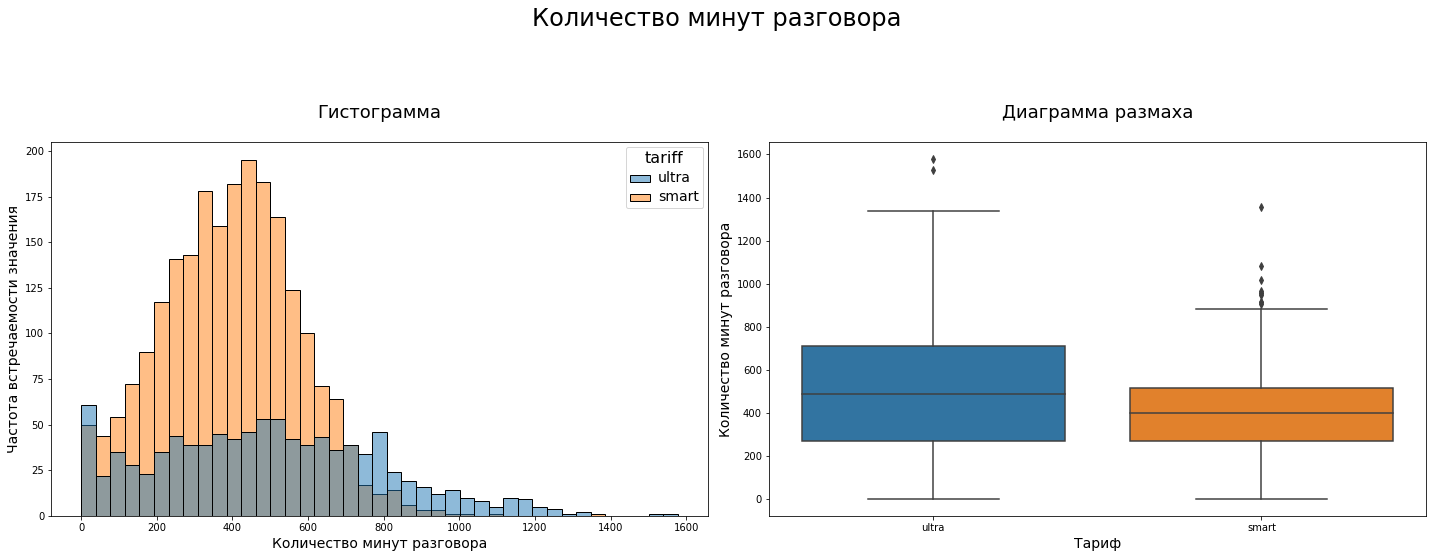

number_of_messages                       
                     mean median      var    std
tariff                                          
smart               33.38   28.0   796.81  28.23
ultra               49.36   38.0  2285.27  47.80

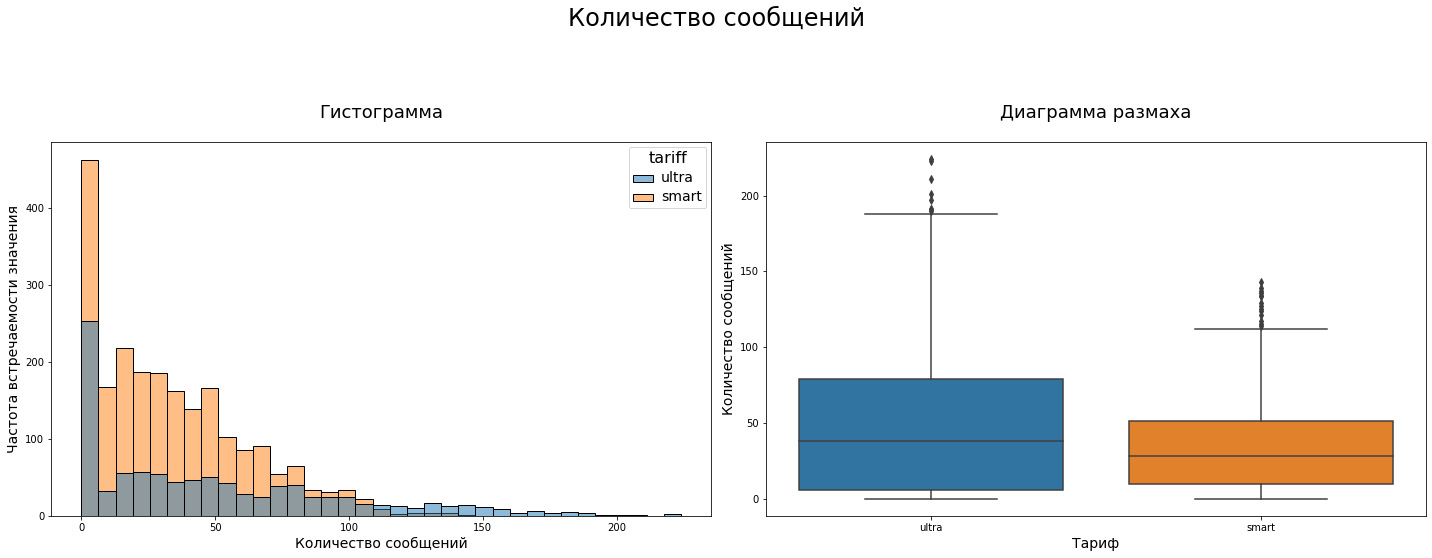

total_mb_used                                  
                mean    median           var       std
tariff                                                
smart       16208.39  16506.84  3.446250e+07   5870.48
ultra       19468.81  19308.01  1.017510e+08  10087.17

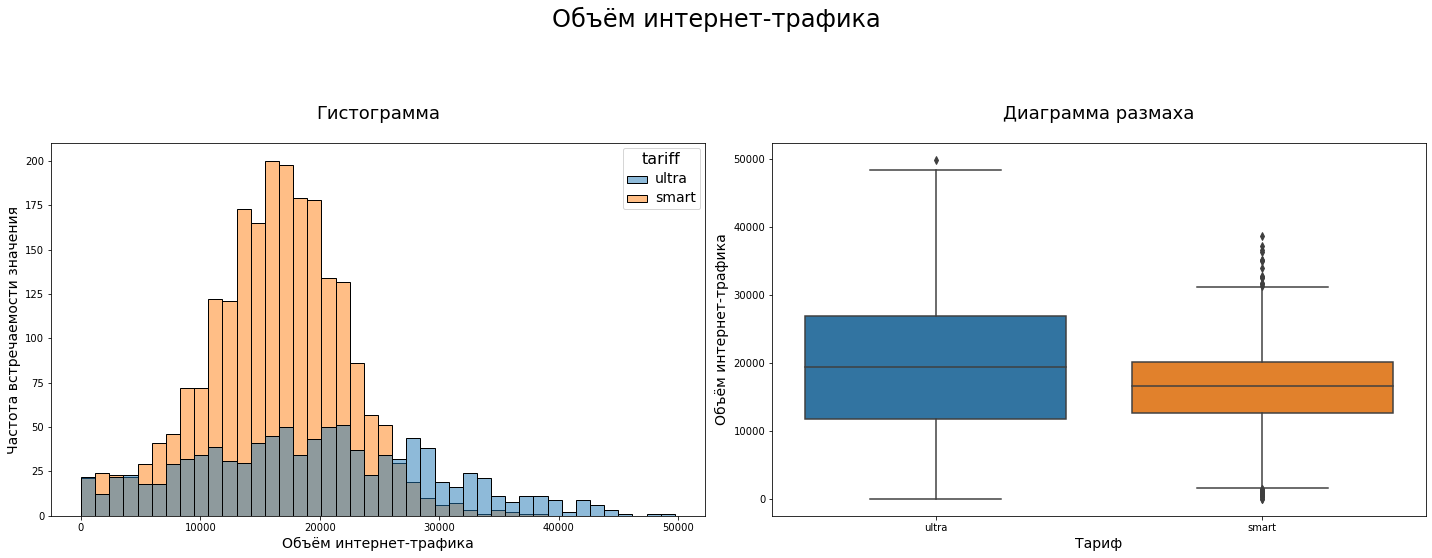

In [50]:
parameters = ['total_duration', 'number_of_messages', 'total_mb_used']
suptitles = ['Количество минут разговора', 'Количество сообщений', 'Объём интернет-трафика']
for i, value in enumerate(parameters):
    output_results(value, suptitles[i])

**Выводы:**

 **1. Минуты разговора**

Большинство пользователей тарифа "Смарт" не превышают установленного лимита по минутам разговора: при фиксированном пакете в 500 мин в среднем пользователь расходует около 400. Для тарифа "Ультра" признак распределен более широко: есть пользователи, которые расходуют больше 800 минут в месяц, в то же время многие и вовсе не пользуются мобильной связью.

Медианное значение расхода минут/ включено в пакет:
 - тариф "Смарт" - 398/500;
 - тариф "Ультра" - 488/3000.

**2. Количество сообщений**

Тарифный план "Смарт" предусматривает небольшой пакет сообщений в размере 50 смс в противовес премиальному тарифу "Ультра", предлагающему своим клиентам пакет в 1000 смс. На гистограммах для обоих тарифов хорошо видны моды, соответствующие очень невысокому расходу сообщений. Как и в случае с минутами звонков, разброс потраченных смс клиентами премиального тарифа более широкий.

Медианное значение расхода смс/ включено в пакет:
 - тариф "Смарт" - 28/50;
 - тариф "Ультра" - 19/1000.

**3. Объём интернет-трафика**

Медианное значение расхода интернет-трафика тарифа "Смарт" превышает установленный лимит в отличие от медианного расхода тарифа "Ультра". Как и для остальных услуг, разброс признака распределен более широко.

Медианное значение расхода интернет-трафика/ включено в пакет:
 - тариф "Смарт" - 16/15;
 - тариф "Ультра" - 19/30.

## Проверка гипотез

Проверим следующие гипотезы:

 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
 - средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.

Проверка равенства средних двух генеральных совокупностей начинается с формулирования ***нулевой*** и ***альтернативной гипотез*** и задания уровня значимости ***α***:

- $H_0$ - ***нулевая гипотеза*** - гипотеза об отсутствии статистически значимых различий в исследуемых совокупностях;
- $H_1$ - ***альтернативная гипотеза*** - гипотеза о наличии статистически значимых различий в исследуемых совокупностях.

Далее из двух генеральных совокупностей извлекаются выборки, для которых средние значения и стандартные отклонения, согласно ЦПТ, равняются средним значениям и стандартным отклонениям генеральных совокупностей. Затем оценивается вероятность того, что среднее выборки, взятой из одной генеральной совокупности, попадет в распределение средних другой совокупности. И если эта вероятность оказывается ниже установленного порогового значения, считается, что получить такой результат случайно было маловероятно, и нулевая гипотеза отвергается.

### Гипотеза 1: о средней выручке тарифов

1. Сформулируем нулевую и альтернативную гипотезы:

- $H_0$ - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны;
- $H_1$ - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

2. Зададим уровень статистической значимости, равным 0,05: ***α = 0,05***.

3. Проверим гипотезу


In [51]:
revenue_smart = (all_pivot[all_pivot['tariff']=='smart']
                 .groupby('user_id')['revenue'].agg('median')) # сводная таблица со средней выручкой пользователй "Смарт"

revenue_ultra = (all_pivot[all_pivot['tariff']=='ultra']
                 .groupby('user_id')['revenue'].agg('median')) # сводная таблица со средней выручкой пользователй "Ультра"


alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(revenue_smart, 
             revenue_ultra,
             equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.5680720243601638e-77
Отвергаем нулевую гипотезу


Посмотрим описательную статистику по выручке пользователей обоих тарифов.

In [52]:
display('Описательная статистика по выручке пользователей тарифа "Смарт"',
        all_pivot[all_pivot['tariff']=='smart']['revenue'].describe().reset_index())
display()
display('Описательная статистика по выручке пользователей тарифа "Ультра"',
        all_pivot[all_pivot['tariff']=='ultra']['revenue'].describe().reset_index())

'Описательная статистика по выручке пользователей тарифа "Смарт"'

,index,revenue
0,count,2229.000000
1,mean,1147.756842
2,std,736.563904
3,min,550.000000
4,25%,550.000000
5,50%,950.000000
6,75%,1550.000000
7,max,5150.000000


'Описательная статистика по выручке пользователей тарифа "Ультра"'

,index,revenue
0,count,985.000000
1,mean,2070.152284
2,std,376.187114
3,min,1950.000000
4,25%,1950.000000
5,50%,1950.000000
6,75%,1950.000000
7,max,4800.000000


Для наглядности построим диаграммы размаха для средней выручки пользователей обоих тарифов:

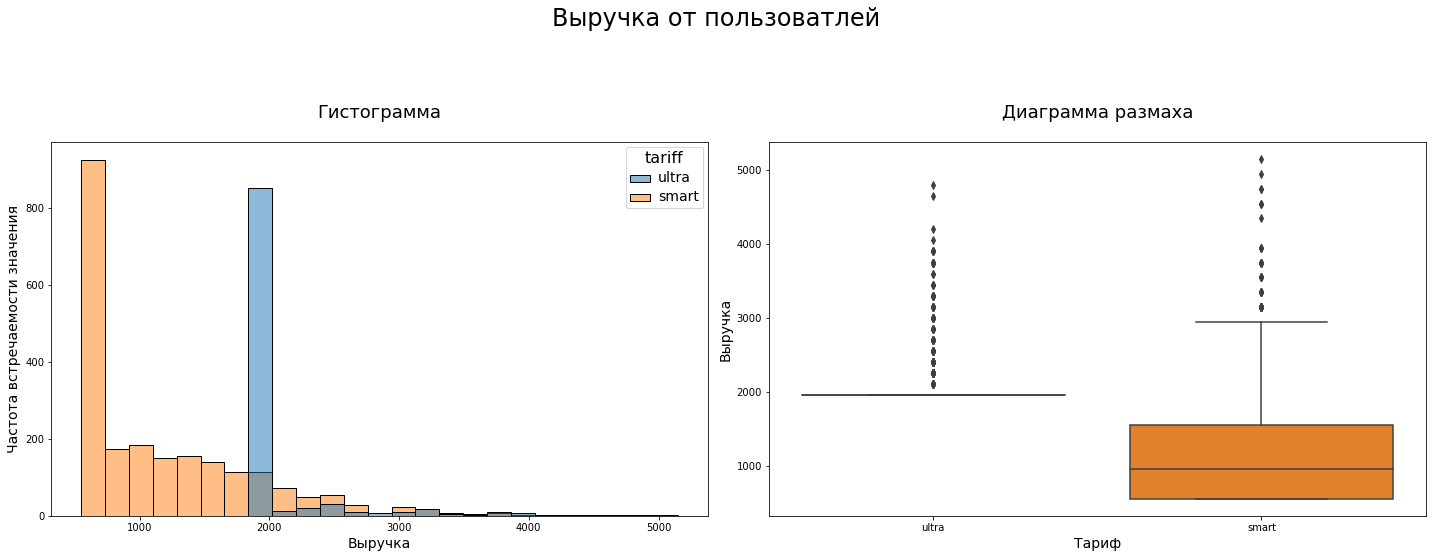

In [53]:
def plot_graphs(parameter):
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    sns.histplot(data=all_pivot, x='revenue', hue=parameter, ax=axes[0])
    axes[0].set_title('Гистограмма', y=1.05, fontsize=18)
    axes[0].set_xlabel('Выручка', fontsize=14)
    axes[0].set_ylabel('Частота встречаемости значения', fontsize=14)
    plt.setp(axes[0].get_legend().get_texts(), fontsize='14') 
    plt.setp(axes[0].get_legend().get_title(), fontsize='16')

    sns.boxplot(x=parameter, y='revenue', data=all_pivot, ax=axes[1])
    axes[1].set_title('Диаграмма размаха', y=1.05, fontsize=18)
    axes[1].set_xlabel('Тариф', fontsize=14)
    axes[1].set_ylabel('Выручка', fontsize=14)

    fig.suptitle('Выручка от пользоватлей', y=1.1, fontsize=24)

    plt.tight_layout()
    plt.show()
    
plot_graphs('tariff')

**Вывод**

Полученное значение p-value значительно меньше принятого уровня значимости значимости **α**, что дает основание отвергнуть нулевую гипотезу $H_0$. Как видно из диаграммы размаха, такая низка вероятность связана с тем, что 75% пользователей тарифа "Смарт" тратят меньше фиксированной абонентской платы тарифа "Ультра". Еще из таблицы с описательной статистикой по выручке можно заметить, что 3/4 пользователей тарифа "Смарт" не укладываются в стандартный пакет услуг. Большинство же пользователей тарифа "Ультра" не превышают установленных тарифных лимитов.


### Гипотеза 2: о выручке пользователей разных регионов

1. Сформулируем нулевую и альтернативную гипотезы:

- $H_0$ - средняя выручка от пользователей из Москвы и выручка от пользователей из других регионов одинаковы;
- $H_1$ - средняя выручка от пользователей из Москвы не равна выручке клиентов из регионов.

2. Зададим уровень статистической значимости, равным 0,05: ***α = 0,05***.

3. Проверим гипотезу

Для начала добавим в итоговую таблицу `all_pivot` столбец, содержащий информацию о городах проживания пользователей. 

In [54]:
all_pivot = all_pivot.merge(users[['user_id', 'city']], how='left', on='user_id')
all_pivot['is_moscow'] = all_pivot['city']=='москва'
all_pivot.sample(3)

,user_id,tariff,month,number_of_calls,total_duration,number_of_messages,total_mb_used,rub_monthly_fee,revenue,city,is_moscow
566,1089,ultra,12,62.0,448.41,143.0,16369.41,1950,1950.0,иркутск,False
386,1061,smart,9,77.0,530.20,8.0,18582.97,550,1350.0,санкт-петербург,False
393,1063,ultra,5,120.0,666.90,0.0,21547.26,1950,1950.0,тула,False


In [55]:
revenue_moscow = (all_pivot[all_pivot['city']=='москва']
                 .groupby('user_id')['revenue'].agg('median')) # сводная таблица со средней выручкой пользователй из Москвы

revenue_regions = (all_pivot[all_pivot['city']!='москва']
                 .groupby('user_id')['revenue'].agg('median')) # сводная таблица со средней выручкой пользователй из регионов

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(revenue_moscow, 
             revenue_regions,
             equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.39708629391742856
Не получилось отвергнуть нулевую гипотезу


Посмотрим описательную статистику по выручке пользователей из Москвы и регионов.

In [56]:
display('Описательная статистика по выручке пользователей из Москвы', 
        all_pivot[all_pivot['city']=='москва']['revenue'].describe().reset_index())
display()
display('Описательная статистика по выручке пользователей из регионов', 
        all_pivot[all_pivot['city']!='москва']['revenue'].describe().reset_index())

'Описательная статистика по выручке пользователей из Москвы'

,index,revenue
0,count,611.000000
1,mean,1464.402619
2,std,750.517042
3,min,550.000000
4,25%,550.000000
5,50%,1750.000000
6,75%,1950.000000
7,max,4550.000000


'Описательная статистика по выручке пользователей из регионов'

,index,revenue
0,count,2603.000000
1,mean,1422.474068
2,std,780.415858
3,min,550.000000
4,25%,550.000000
5,50%,1350.000000
6,75%,1950.000000
7,max,5150.000000


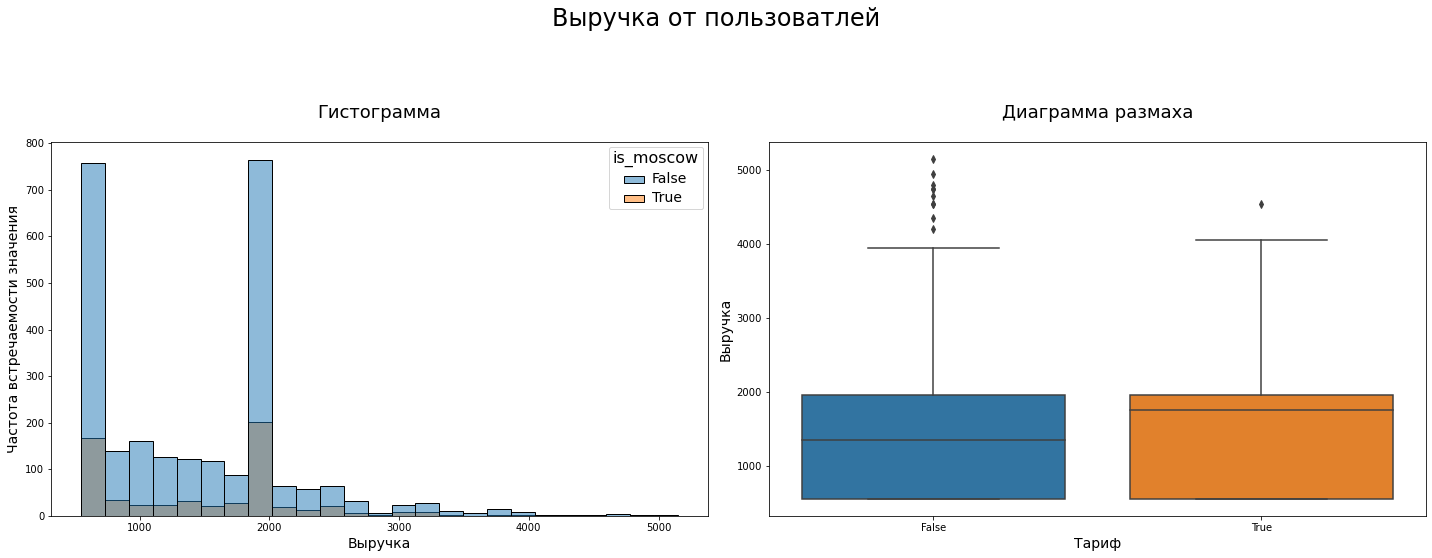

In [57]:
plot_graphs('is_moscow')

**Вывод**

Полученное значение **p-value**, равное 0.397, больше принятого уровня значимости значимости **α**, что не дает оснований отвергнуть нулевую гипотезу $H_0$ о равенстве выручек от пользователей из Москвы и регионов. На гистограммах хорошо видны моды, соответствующие ежемесячной абоненсткой плате. Характер распределений выручки от пользователей Москвы и регионов схож.

Итак, по результатам проведенных расчетов можно сделать следующие **выводы**:

- Выручка от пользователей тарифов "Смарт" и "Ультра" отличаются;
- Разница доходов от пользователей из Москвы и из регионов статистически не значима.

## Общие выводы

1. В ходе исследовательского анализа поведения пользователей двух тарифных планов "Смарт" и "Ультра" было обнаружено, что клиенты премиального тарифа имеют более разнообразный профиль расходов на мобильную связь, например, могут практически не пользоваться пакетом услуг, при этом продолжая платить высокую абонентскую плату. В целом, по основным показателям средняя активность пользователей тарифа "Ультра" выше:

- Медианное значение расхода **минут разговора**/ включено в пакет:

 - тариф "Смарт" - 398/500;
 - тариф "Ультра" - 488/3000.

- Медианное значение **количества сообщений**/ включено в пакет:

 - тариф "Смарт" - 28/50;
 - тариф "Ультра" - 19/1000.

- Медианное значение **объёма интернет-трафика**/ включено в пакет:
 - тариф "Смарт" - 16/15;
 - тариф "Ультра" - 19/30. 

2. Пользователи тарифа "Смарт" часто не укладываются в стандартный пакет услуг. Однако, мало кому из выборки переход на тариф "Ультра" позволил бы сэкономить деньги.

3. Объем пакетов минут и сообщений в тарифе "Ультра" избыточен - большинство пользователей не используют и половины. 

4. Наибольший доход в среднем приносят абоненты "Ультра", особенно учитывая то, что они редко пользуются тарифом полноценно.

5. Разница доходов от пользователей из Москвы и из регионов статистически не значима.